# Setting up environment

In [0]:
!pip install tf-nightly
import tensorflow_datasets as tfds

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

# Preparing dataset

In [4]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_examples, test_examples = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCZ3O9B/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCZ3O9B/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteCZ3O9B/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = (train_examples
                 .shuffle(BUFFER_SIZE)
                 .padded_batch(BATCH_SIZE))

test_dataset = (test_examples
                .padded_batch(BATCH_SIZE))

# Model defination and training

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [0]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
__________________________________________________

In [10]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 78s 199ms/step - loss: 0.6565 - accuracy: 0.5470 - val_loss: 0.5704 - val_accuracy: 0.7292
Epoch 2/10
391/391 [==============================] - 78s 199ms/step - loss: 0.4407 - accuracy: 0.8100 - val_loss: 0.4255 - val_accuracy: 0.8094
Epoch 3/10
391/391 [==============================] - 78s 200ms/step - loss: 0.3353 - accuracy: 0.8736 - val_loss: 0.4311 - val_accuracy: 0.8115
Epoch 4/10
391/391 [==============================] - 79s 201ms/step - loss: 0.2833 - accuracy: 0.8974 - val_loss: 0.3724 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 79s 201ms/step - loss: 0.2335 - accuracy: 0.9211 - val_loss: 0.3683 - val_accuracy: 0.8490
Epoch 6/10
391/391 [==============================] - 78s 200ms/step - loss: 0.2021 - accuracy: 0.9342 - val_loss: 0.4087 - val_accuracy: 0.8651
Epoch 7/10
391/391 [==============================] - 79s 201ms/step - loss: 0.1747 - accuracy: 0.9473 - val_loss: 0.4105 - val_ac

In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

391/391 [==============================] - 31s 78ms/step - loss: 0.4394 - accuracy: 0.8477
Test Loss: 0.4394134283065796
Test Accuracy: 0.8477200269699097


# Plotting learning curves

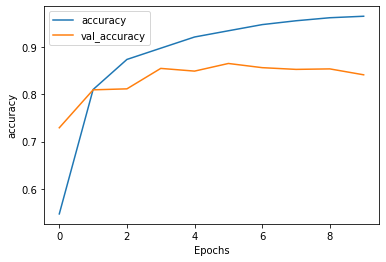

In [12]:
plot_graphs(history, 'accuracy')

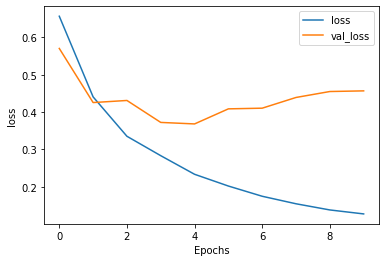

In [13]:
plot_graphs(history, 'loss')

In [0]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  if predictions >= 0.5:
    return ("Positive", predictions)
  
  return ("Negative", predictions)

# Predicting new Movie Reviews

In [26]:
# Enter text to predict with padding:

sample_pred_text = ('The movie was very good. The animation and the graphics were perfect. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

('Positive', array([[3.1862988]], dtype=float32))


In [27]:
# Enter text to predict without padding:

sample_pred_text = ('The movie was very good. The animation and the graphics were perfect. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

('Positive', array([[1.495632]], dtype=float32))


In [28]:
# Enter text to predict with padding:

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

('Negative', array([[-1.5407181]], dtype=float32))


In [29]:
# Enter text to predict without padding:

sample_pred_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

('Negative', array([[-1.4039901]], dtype=float32))


In [23]:
model.save('imdb_sentimental_model')

INFO:tensorflow:Assets written to: imdb_sentimental_model/assets


INFO:tensorflow:Assets written to: imdb_sentimental_model/assets


In [30]:
!zip -r imdb_sentimental_model.zip imdb_sentimental_model

  adding: imdb_sentimental_model/ (stored 0%)
  adding: imdb_sentimental_model/variables/ (stored 0%)
  adding: imdb_sentimental_model/variables/variables.data-00000-of-00002 (deflated 9%)
  adding: imdb_sentimental_model/variables/variables.index (deflated 71%)
  adding: imdb_sentimental_model/variables/variables.data-00001-of-00002 (deflated 6%)
  adding: imdb_sentimental_model/saved_model.pb (deflated 91%)
  adding: imdb_sentimental_model/assets/ (stored 0%)
